## Predicting credit card defaults from UCI ML credit card clients data set

In [1]:
import xlrd
import pandas as pd
import pylab as pl
import numpy as np
from scipy import stats
import scipy.optimize as opt
from sklearn import preprocessing
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

Let's read the file, create a dataframe and change the label of target variable column to a shorter one.

In [2]:
file = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
cd_df = pd.read_excel(file, sheet_name='Data',skiprows=range(1))
cd_df.rename(columns={'default payment next month':'default'}, inplace=True)

In [3]:
cd_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


First, let's look what's the proportion of defaulting customers in our data set.

In [21]:
d = min(cd_df['default'].value_counts())
print('The number of defaulting customers in database:', d)
print('% of defaulting customers:', d/30000*100)

The number of defaulting customers in database: 6636
% of defaulting customers: 22.12


More than one in five customers will default the card payment next month. That's pretty high... <br>
OK, let's check for the distribution of the data variables and outliers

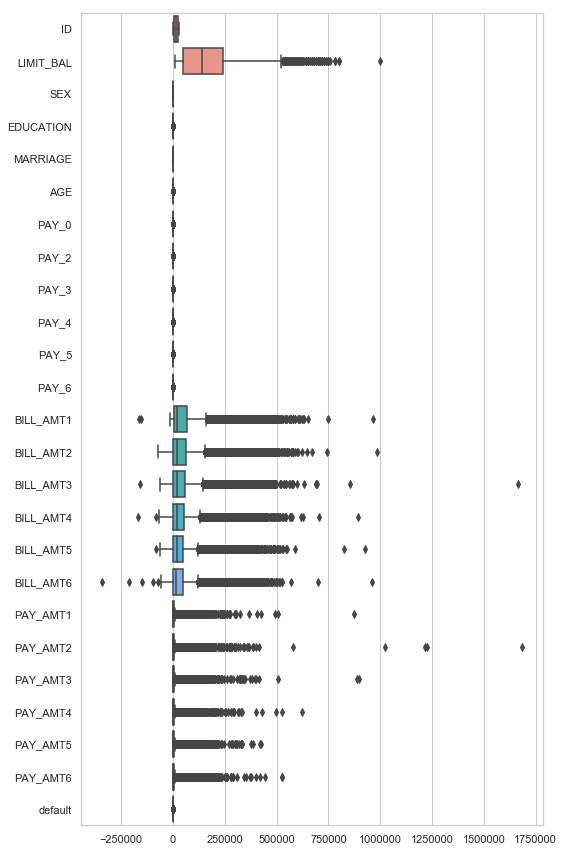

In [53]:
sns.set(style="whitegrid")
g = sns.boxplot(data = cd_df, orient = 'h')
g.figure.set_size_inches(8,12)
plt.tight_layout()
plt.show()

There are quite a few outliers, let's remove rows with data point z-score>3 and assign to a new dataframe

In [13]:
z = np.abs(stats.zscore(cd_df))
cd_df_o = cd_df[(z < 3).all(axis=1)]

Check the data dimensions now

In [14]:
cd_df_o.shape

(26429, 25)

Plot the histograms onece again

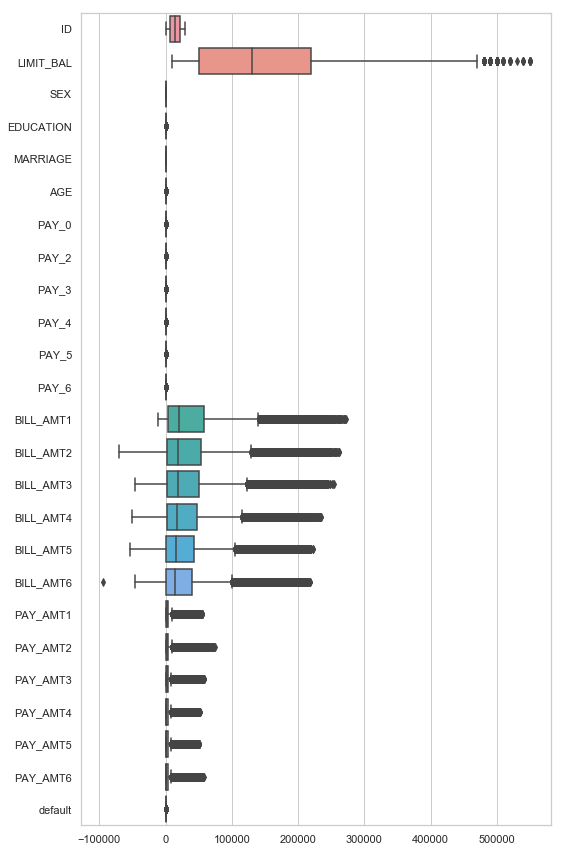

In [16]:
sns.set(style="whitegrid")
g = sns.boxplot(data = cd_df_o, orient = 'h')
g.figure.set_size_inches(8,12)
plt.tight_layout()
plt.show()

Now lets check the correlation between independent variables

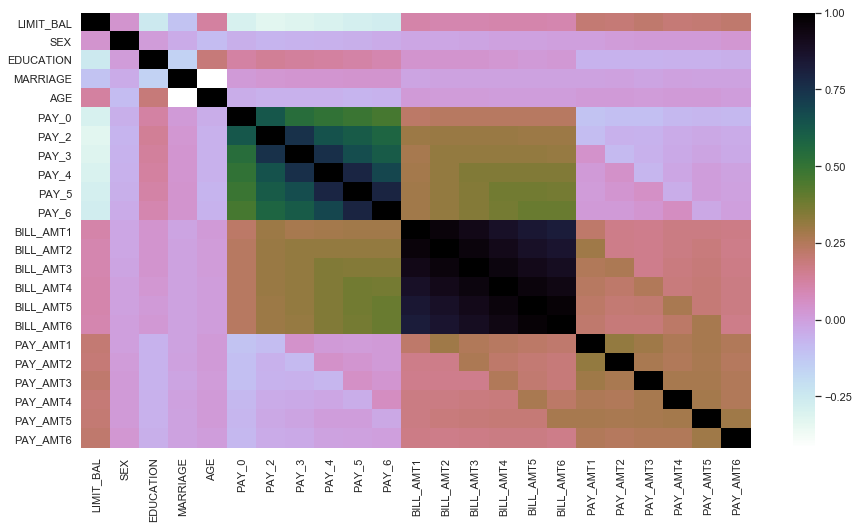

In [22]:
cd_df1 = cd_df_o.drop(['ID','default'],1)
cd_cor = cd_df1.corr()

plt.figure(figsize=(15,8))
colormap = plt.cm.cubehelix_r
ax = sns.heatmap(cd_cor, cmap=colormap)

We can see that variables "BILL_AMT(1-6)" have high correlation, so let's join them into one variable that has their mean value. 

In [23]:
col = cd_df1.loc[: , "BILL_AMT1":"BILL_AMT6"]
cd_df1['bill_mean'] = col.mean(axis=1)

Variables "PAY_(0-6)" also have high correlation. Their values represent number of monhts the payments have been delayed with '-1' indicating payment on time. Therefor we are interested only in maximal value of these 6 variables. 

In [24]:
col2 = cd_df1.loc[: , 'PAY_0':'PAY_6']
cd_df1['pay_delay'] = col2.max(axis=1)

Now let's drop columns that wont be used in the model from cd_df1 dataframe.

In [26]:
cd_df2 = cd_df1.drop(['PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6','BILL_AMT1', 'BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6' ],1)

In [27]:
cd_df2.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'bill_mean',
       'pay_delay'],
      dtype='object')

Let's create arrays for train and test sets...

In [28]:
X = np.asarray(cd_df2)
y = np.asarray(cd_df_o[['default']])

...and normalise the data before fiting it to logistic regression model.

In [30]:
X = preprocessing.StandardScaler().fit(X).transform(X)

Now we can split data into train ad test data sets.

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (21143, 13) (21143, 1)
Test set: (5286, 13) (5286, 1)


Fit the model using logistic regression. Assign small C parameter to avoid overfitting.

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

LR = LogisticRegression(C=0.01,class_weight='balanced', solver='saga',max_iter=100).fit(X_train,y_train.ravel())
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)

Calculate model accuracy

In [42]:
from sklearn.metrics import log_loss
from sklearn.metrics import jaccard_similarity_score

print('Jaccard similarity score is', jaccard_similarity_score(y_test, yhat))
print('Log-loss score is',log_loss(y_test, yhat_prob))

Jaccard similarity score is 0.7079076806659099
Log-loss score is 0.6057339255949502


Now lets plot ROC curve and calculate Area Under the Curve (AUC) indicator

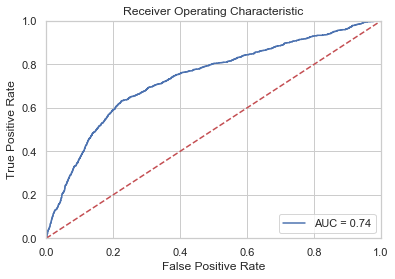

In [43]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = LR.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# create the plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

We can also find the optimal threshold level that maximises both precision and recall values.

(0, 1)

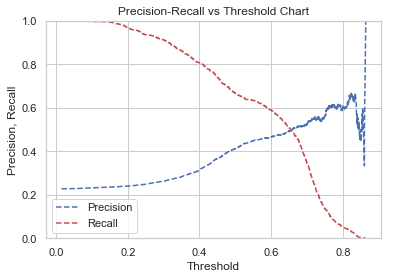

In [44]:
### Predict test_y values and probabilities based on fitted logistic regression model

y_pred=LR.predict(X_test) 

y_probs=LR.predict_proba(X_test) 
# probs_y is a 2-D array of probability of being labeled as 0 (first column of   array) vs 1 (2nd column in array)

import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:,1]) 

#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Lets create a function that plots confusion matrix and its indicators.

In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 803  402]
 [1142 2939]]


Lets plot the confusion matrix.

Confusion matrix, without normalization
[[ 803  402]
 [1142 2939]]


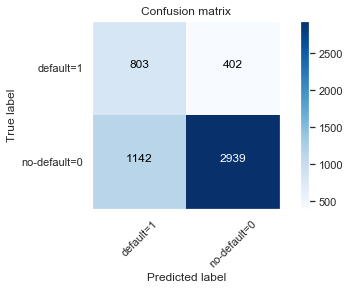

In [48]:
sns.set(style="dark")
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['default=1','no-default=0'],normalize= False,  title='Confusion matrix')

In [68]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.88      0.72      0.79      4081
           1       0.41      0.67      0.51      1205

   micro avg       0.71      0.71      0.71      5286
   macro avg       0.65      0.69      0.65      5286
weighted avg       0.77      0.71      0.73      5286



Here we can see that our model provides 67% recall rate - that is **more than 300% increase** over the sample average. <br> 

In [57]:
TP = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TN = cnf_matrix[1][1]
FPR = TP/(FP+TN)

print('False positive rate: %.2f' % FPR)

False positive rate: 0.24


The weak point of the model is its relatively high FPR and precision rate. Recall and precision rates can be adjusted by changing the decision threshold.